In [2]:
import pandas as pd
import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from tensorflow.keras.metrics import AUC
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Conv2D, GlobalMaxPool2D, GlobalAveragePooling2D,
                                     Dropout, Flatten, Dense, Activation, Dropout,
                                     BatchNormalization, MaxPooling2D)
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import (ModelCheckpoint, LearningRateScheduler, 
                                        EarlyStopping, CSVLogger, TerminateOnNaN,
                                       ReduceLROnPlateau)
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.notebook_repr_html', True)

In [ ]:
mobilenet_model = load_model(r'C:\Users\Yaroslavel\ZalevskiyDiplom\models\mobile_net_cnn1.h5')
final_dx = pd.read_pickle('ZalevskiyDiplom/dataframes/fixed_final_df.pkl')
train_set = pd.read_pickle('ZalevskiyDiplom/sample/new_train_set.pkl')
valid_set = pd.read_pickle('ZalevskiyDiplom/sample/new_valid_set.pkl')
test_set = pd.read_pickle('ZalevskiyDiplom/sample/new_test_set.pkl')

In [40]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
mobilenet_log = pd.read_csv('mobienet_best_logger.csv')
mobilenet_log

,epoch,auc_4,categorical_accuracy,loss,lr,val_auc_4,val_categorical_accuracy,val_loss
0,0,0.788147,0.187127,0.162989,0.001,0.789811,0.141602,0.163646
1,1,0.799813,0.189177,0.160241,0.001,0.804840,0.199646,0.158920
2,2,0.806734,0.194432,0.158618,0.001,0.775023,0.142212,0.175606
3,3,0.811266,0.197842,0.157567,0.001,0.811921,0.184814,0.157150
4,4,0.816687,0.203544,0.156175,0.001,0.827867,0.186218,0.153544
5,5,0.822412,0.208091,0.154916,0.001,0.816951,0.333649,0.159098
6,6,0.827274,0.214557,0.153598,0.001,0.825644,0.323303,0.154032
7,7,0.830673,0.219849,0.152686,0.001,0.835397,0.189819,0.151347
8,8,0.831685,0.217967,0.152520,0.001,0.834999,0.221802,0.151434
9,9,0.836964,0.224620,0.150952,0.001,0.816930,0.211121,0.159120


In [50]:
fig = go.Figure()
epoch = mobilenet_log.epoch
# fig.add_trace(go.Scatter(x=epoch,y = mobilenet_log.loss,name='Потери на обучении',marker_color='red'))
# fig.add_trace(go.Scatter(x=epoch,y= mobilenet_log.val_loss,name='Потери на валидации',marker_color='steelblue'))

#fig.add_trace(go.Scatter(x=epoch, y=  mobilenet_log.categorical_accuracy, name='Категориальная точность',marker_color='red'))
#fig.add_trace(go.Scatter(x=epoch, y=  mobilenet_log.val_categorical_accuracy, name='Категориальная точность на валидации',marker_color='lightskyblue'))

fig.add_trace(go.Scatter(x=epoch, y=mobilenet_log.auc_4,name='AUC на обучении',marker_color='red'))
fig.add_trace(go.Scatter(x=epoch, y=mobilenet_log.val_auc_4,name='AUC на валидации',marker_color='steelblue'))

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0),template='plotly_white', height=500, width=475,
                  legend=dict(x=.5, xanchor="center"),title_text="Model History")
                    
fig.update_yaxes(title_text="AUC")
fig.update_xaxes(title_text="Эпоха")
fig.show()

In [7]:
path_to_images = 'K:/DiplomZalevskiy/data/images/'
disease_labels = ['Atelectasis',
       'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
       'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
       'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']

image_generator = ImageDataGenerator(rescale=1./255.,
                         samplewise_center=True,
                         samplewise_std_normalization=True,
                         horizontal_flip=False,
                         vertical_flip=False,
                         height_shift_range=0.1,
                         width_shift_range=0.1,
                         rotation_range=5,
                         shear_range=0.1,
                         fill_mode='reflect',
                         zoom_range=0.15)


test_generator = image_generator.flow_from_dataframe(
    dataframe=test_set,
    directory=path_to_images,
    x_col="filename",
    y_col=disease_labels,
    classes=disease_labels,
    target_size=(128, 128),
    seed=42,
    class_mode='raw',
    color_mode='rgb',
    batch_size=2048,
    shuffle=False)


C:\Users\Yaroslavel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:930: UserWarning: `classes` will be ignored given the class_mode="raw"
  warnings.warn(


Found 19724 validated image filenames.


In [36]:
x_test,y_test = next(test_generator)

In [37]:
predict_y = mobilenet_model.predict(x_test)

64/64 [==============================] - 5s 77ms/step


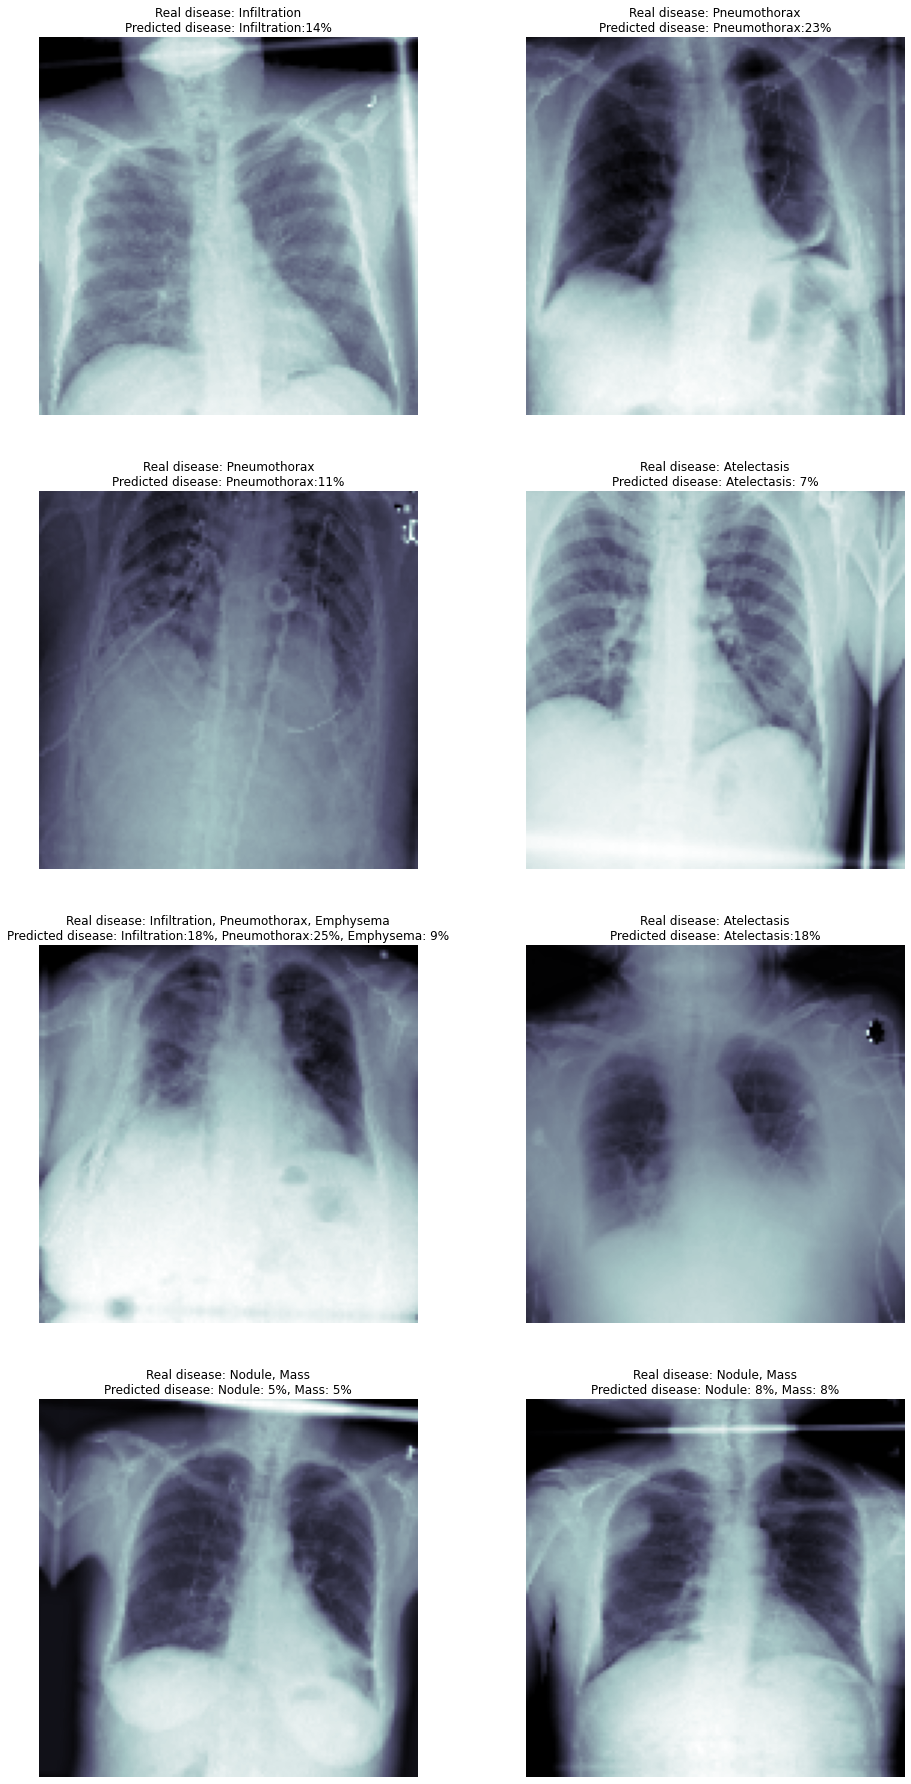

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
sickest_idx = np.argsort(np.sum(y_test, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(x_test[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class for n_class, n_score in zip(disease_labels, y_test[idx]) if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class, p_score*100)  for n_class, n_score, p_score in zip(disease_labels, 
                                                                  y_test[idx], predict_y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Real disease: '+', '.join(stat_str)+'\nPredicted disease: '+', '.join(pred_str))
    c_ax.axis('off')